In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec
import cartopy.crs as ccrs
import seaborn as sns
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import data
snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')
all_fbs = np.load('/Users/carmennab/PhD/OI_PolarSnow/robbiefreebs.npy')


In [3]:
# do smooth anoms for each grid cell

T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 30 day running mean (15 either side)
    
    snows_30day = np.nanmean(snow[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    freeb_30day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 30 day means
    
    snows_anoms_big[day] = snow[day] - snows_30day 
    freeb_anoms_big[day] = all_fbs[day] - freeb_30day
    

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)
# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:04<00:00, 876.68it/s]


In [4]:
ps_map = np.full((160,160), np.nan)
ss_map = np.full((160,160), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(fb_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        r = rstats.slope
        p = rstats.pvalue
        ps_map[i,j] = p
        ss_map[i,j] = r

25600it [00:01, 13875.31it/s]


In [5]:
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017',
           '2017-2018','2018-2019','2019-2020']
#seasons: 01/10 - 30/04
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

In [6]:
all_MYI = []
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

all_MYI=np.full((4018,1120, 760),np.nan)

for day in days:#key is a date, so looping through each day for which we have gridded CS2 obs in this season
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_polstere-100_multi_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
day_ave = MYI_days/total
day_ave[icetype_lat>89]=0.6 # remove polehole

In [7]:
# load data
df = pd.read_csv('/Users/carmennab/PhD/OI_PolarSnow/dataframes/WG_vs_SM_regional_anomalies_smoothed.csv',header=[0,1,2])
regions = ['Baffin','Greenland','Barents','Kara','Laptev','Sib','Chuk','Bea','Can','Cen']
random_SM = ['Unnamed: 91_level_2','Unnamed: 92_level_2','Unnamed: 93_level_2','Unnamed: 94_level_2','Unnamed: 95_level_2','Unnamed: 96_level_2','Unnamed: 97_level_2','Unnamed: 98_level_2',
             'Unnamed: 99_level_2','Unnamed: 100_level_2']
        
def stats():
    fb = df[sat][region][rando_C][day]
    snow = df['SM'][region][rando_S][day]
    mask = ~np.isnan(snow) & ~np.isnan(fb) 
    try:
        rstats = linregress(snow[mask],fb[mask])
        s = rstats.slope
        p = rstats.pvalue
        return(p,s)
    except:
        print(region,': no data')

In [8]:
Baf = {}
Green = {}
Bar = {}
Kara = {}
Laptev = {}
Sib = {} 
Chuk = {} 
Bea = {}
Can = {}
Cen = {}

ps_table = np.full((10,10),np.nan)

counters = np.arange(0,10)

dics = [Baf,Green,Bar,Kara,Laptev,Sib,Chuk,Bea,Can,Cen]

random_CPOM = ['Unnamed: 21_level_2','Unnamed: 22_level_2','Unnamed: 23_level_2','Unnamed: 24_level_2','Unnamed: 25_level_2','Unnamed: 26_level_2','Unnamed: 27_level_2','Unnamed: 28_level_2',
               'Unnamed: 29_level_2','Unnamed: 30_level_2']
sat = 'CS2_CPOM'
    
for region, rando_C, rando_S, dic, counter in zip(regions, random_CPOM, random_SM, dics, counters):
    for season, day, count in zip(seasons, dayss, counters):
        p,r = stats()
        dic[season] = r
        ps_table[count,counter] = p
    
df_Baf = pd.DataFrame.from_dict(Baf, columns=[' '], orient = 'index')
df_Green = pd.DataFrame.from_dict(Green, columns=[' '], orient = 'index')
df_Bar = pd.DataFrame.from_dict(Bar, columns=[' '], orient = 'index')
df_Kara = pd.DataFrame.from_dict(Kara, columns=[' '], orient = 'index')
df_Laptev = pd.DataFrame.from_dict(Laptev, columns=[' '], orient = 'index')
df_Sib = pd.DataFrame.from_dict(Sib, columns=[' '], orient = 'index')
df_Chuk = pd.DataFrame.from_dict(Chuk, columns=[' '], orient = 'index')
df_Bea = pd.DataFrame.from_dict(Bea, columns=[' '], orient = 'index')
df_Can = pd.DataFrame.from_dict(Can, columns=[' '], orient = 'index')
df_Cen = pd.DataFrame.from_dict(Cen, columns=[' '], orient = 'index')

sets = [df_Baf,df_Green,df_Bar,df_Kara,df_Laptev,df_Sib,df_Chuk,df_Bea,df_Can,df_Cen] 

df_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['Baffin','Greenland','Barents','Kara', 'Laptev', 'E. Siberian', 'Chukchi', 'Beaufort', 'Can. Arch.','Central Arctic'],
    axis=1)

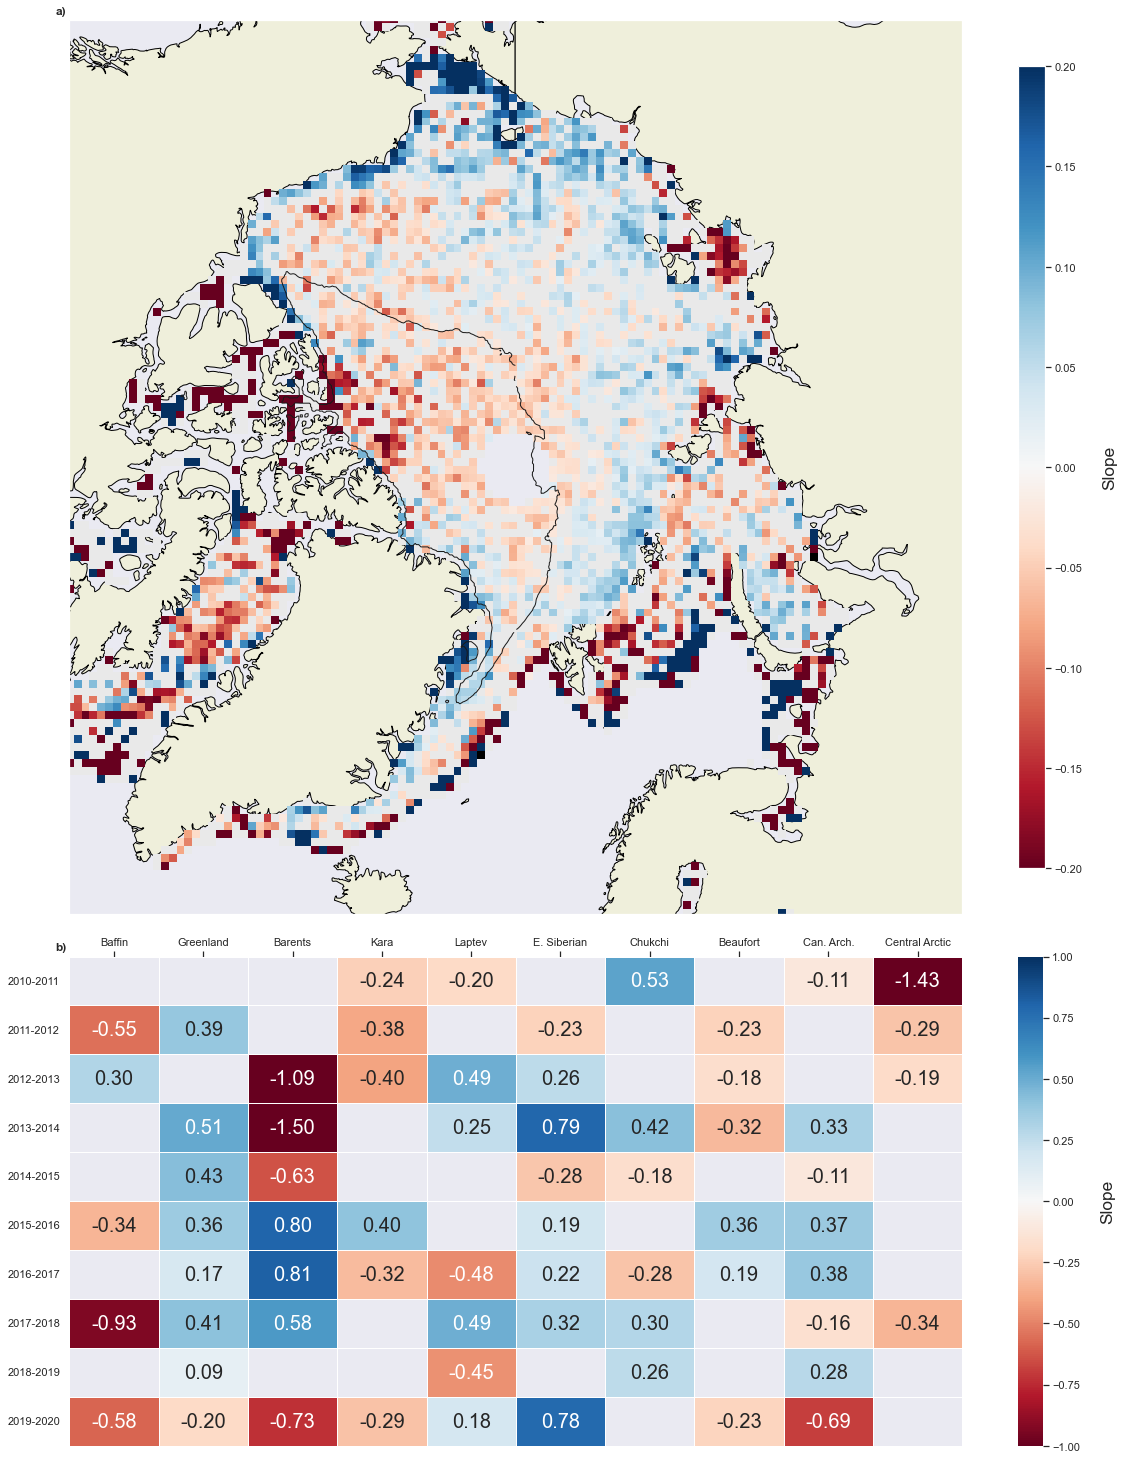

In [13]:
lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

ss_map[ps_map>0.05] = 1000
grey = ss_map.copy()
grey[grey <1000] = np.nan
ss_map[ss_map==1000] = np.nan

fig = plt.figure(figsize=(20,27))
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1],hspace=0)

ax1 = fig.add_subplot(spec[0],projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lons,lats,ss_map,cmap='RdBu',vmin=-0.2,vmax=0.2,alpha=1.0, transform=ccrs.PlateCarree())
ax1.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
ax1.set_title('a)', x = -0.01,y = 1,fontweight="bold")
a = fig.colorbar(p_map,shrink=0.82,aspect=30)
a.set_label("Slope",fontsize='x-large',labelpad=20)

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax1.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

cont_Great = ax1.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

mask = ps_table.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

keys=['Baffin','Greenland','Barents','Kara', 'Laptev', 'E. Siberian', 'Chukchi', 'Beaufort', 'Can. Arch.','Central Arctic']
ax2 = fig.add_subplot(spec[1])
ax2 = sns.heatmap(df_combined, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons)
sns.set(rc = {'figure.figsize':(20,27)})
ax2.xaxis.tick_top()
ax2.set_xlabel(' ')    
ax2.set_yticklabels(seasons,rotation = 0)
ax2.set_xticklabels(keys)
ax2.collections[0].colorbar.set_label("Slope",fontsize='x-large',labelpad=20)
ax2.set_title('b)', x = -0.01,y = 1,fontweight="bold")

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/figures/CS2_SM_slope.png',bbox_inches = "tight")